In [1]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Create initial datasets

### Setup input/output

In [2]:
# set base directory
baseDIR = '/mnt/d'
# set input directory
inDIR = 'TBNG/data/veg/NEX'
# set input file
inXLSX = '2015-2021 Herb_16nov2021ep.xlsx'

### Load data

In [5]:
# create an Excel file object for investigating contents
#nex_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))

nex_xlsx = pd.ExcelFile(os.path.join('T:/2-Projects/Thunder Basin/NestedExclosures/Data/Multi-Year Data/old', inXLSX))

# display the sheet names in the .xlsx file
display(nex_xlsx.sheet_names)

['Metadata 15-20',
 'VOR 15-20',
 'Basal 15-20',
 'Biomass-FQ 15-20',
 'Cover 15-20',
 'Pin Frame 16-20',
 'Pin_Calibration17-20',
 'Pin_CalibClip_Shrubs 17-18',
 'Grouse Pellets 15-19',
 'Ants 15-20',
 'Dung 15-20',
 'PDog_activity 17-20',
 'Fires',
 'SmMammExcl']

In [6]:
# Create the desired dataframes by parsing the individual sheets
df_nex_bm = nex_xlsx.parse(sheet_name='Biomass-FQ 15-20', header=1, usecols='C:AL')
df_nex_pf = nex_xlsx.parse(sheet_name='Pin_Calibration17-20', header=0)
df_nex_vor = nex_xlsx.parse(sheet_name='VOR 15-20', header=0)

# Biomass dataset

#### Clean up dates

In [34]:
# create a mask to identify all values that are 'date-like'
dates_bm_mask = df_nex_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# summarize to find all unique values in the 'Date' column for each year
dates_yrly_bm = pd.DataFrame(df_nex_bm.groupby('Year')['Date'].unique()).explode('Date')
# create a mask of 'date-like' values from the unique values pulled for each year
dates_yrly_bm_mask = dates_yrly_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# create a Series of the 'date-like' unique values
dates_yrly_bm_good = dates_yrly_bm['Date'][dates_yrly_bm_mask].astype(np.datetime64)
# get the average date for each month of each year for manually correcting vague dates
dates_yrly_bm_avgs = dates_yrly_bm_good.groupby(['Year', dates_yrly_bm_good.dt.month_name()]).mean().dt.date

In [35]:
# display the average dates for each month of each year
display(dates_yrly_bm_avgs)

Year  Date  
2016  August    2016-08-02
      July      2016-07-08
2017  July      2017-07-19
2018  August    2018-08-03
      July      2018-07-16
      June      2018-06-16
2019  August    2019-08-06
      July      2019-07-16
      June      2019-06-25
2020  August    2020-08-06
      July      2020-07-07
2021  July      2021-07-07
      June      2021-06-30
Name: Date, dtype: object

In [9]:
# display the unique non-'date-like' values present in each year
display(dates_yrly_bm['Date'][~dates_yrly_bm_mask])

Year
2015                     na
2015           7/20-23/2015
2015          7/27-8/5/2015
2016           6/6-6/9/2016
2016          na, July 2016
2017          na, June 2017
2017          na, July 2017
2017        na, August 2017
2020    7/6/2020 - 7/7/2020
2020    7/8/2020 - 7/9/2020
2020      8/4/2020-8/5/2020
Name: Date, dtype: object

In [10]:
# create a dictionary to manually change non-'date-like' values to dates
dates_bm_dict = {
    2015: {
        'na': pd.to_datetime('2015-07-27').date(),
        '7/20-23/2015': pd.to_datetime('2015-07-21').date(),
        '7/27-8/5/2015': pd.to_datetime('2015-08-01').date()
    },
    2016: {
        'na, July 2016': dates_yrly_bm_avgs.loc[(2016, 'July')],
        '6/6-6/9/2016': pd.to_datetime('2016-06-08').date(),
    },
    2017: {
        'na, June 2017': pd.to_datetime('2017-06-22').date(),
        'na, July 2017': dates_yrly_bm_avgs.loc[(2017, 'July')],
        'na, August 2017': pd.to_datetime('2017-08-04').date(),
    },
    2020: {
        '7/6/2020 - 7/7/2020': pd.to_datetime('2020-07-07').date(),
        '7/8/2020 - 7/9/2020': pd.to_datetime('2020-07-09').date(),
        '8/4/2020-8/5/2020': pd.to_datetime('2020-08-05').date()
    }
}

In [11]:
# Create a new column of cleaned up dates from 'date-like' values and manual replacement
df_nex_bm.loc[dates_bm_mask, 
              'Date_cln'] = df_nex_bm['Date'][dates_bm_mask].astype(np.datetime64).dt.date
df_nex_bm.loc[~dates_bm_mask, 
              'Date_cln'] = df_nex_bm[~dates_bm_mask].apply(lambda x: dates_bm_dict[x.Year][x.Date], axis=1)
df_nex_bm['Date_cln'] = df_nex_bm['Date_cln'].astype(np.datetime64)

### Prep biomass values for joining

In [12]:
# fill all clipping NA values with zeros for averaging
df_nex_bm.loc[:, df_nex_bm.columns.str.contains('weight \(g\)')] = df_nex_bm.loc[:, df_nex_bm.columns.str.contains('weight \(g\)')].fillna(0)

In [13]:
# create columns for aerial density of biomass
for c in [c for c in df_nex_bm.columns if ' (g)' in c]:
    df_nex_bm[re.sub(' \(g\)', ' (g/m^2)', c)] = df_nex_bm[c] / df_nex_bm['Area (m^2)']

### Visualize data to check that it makes sense

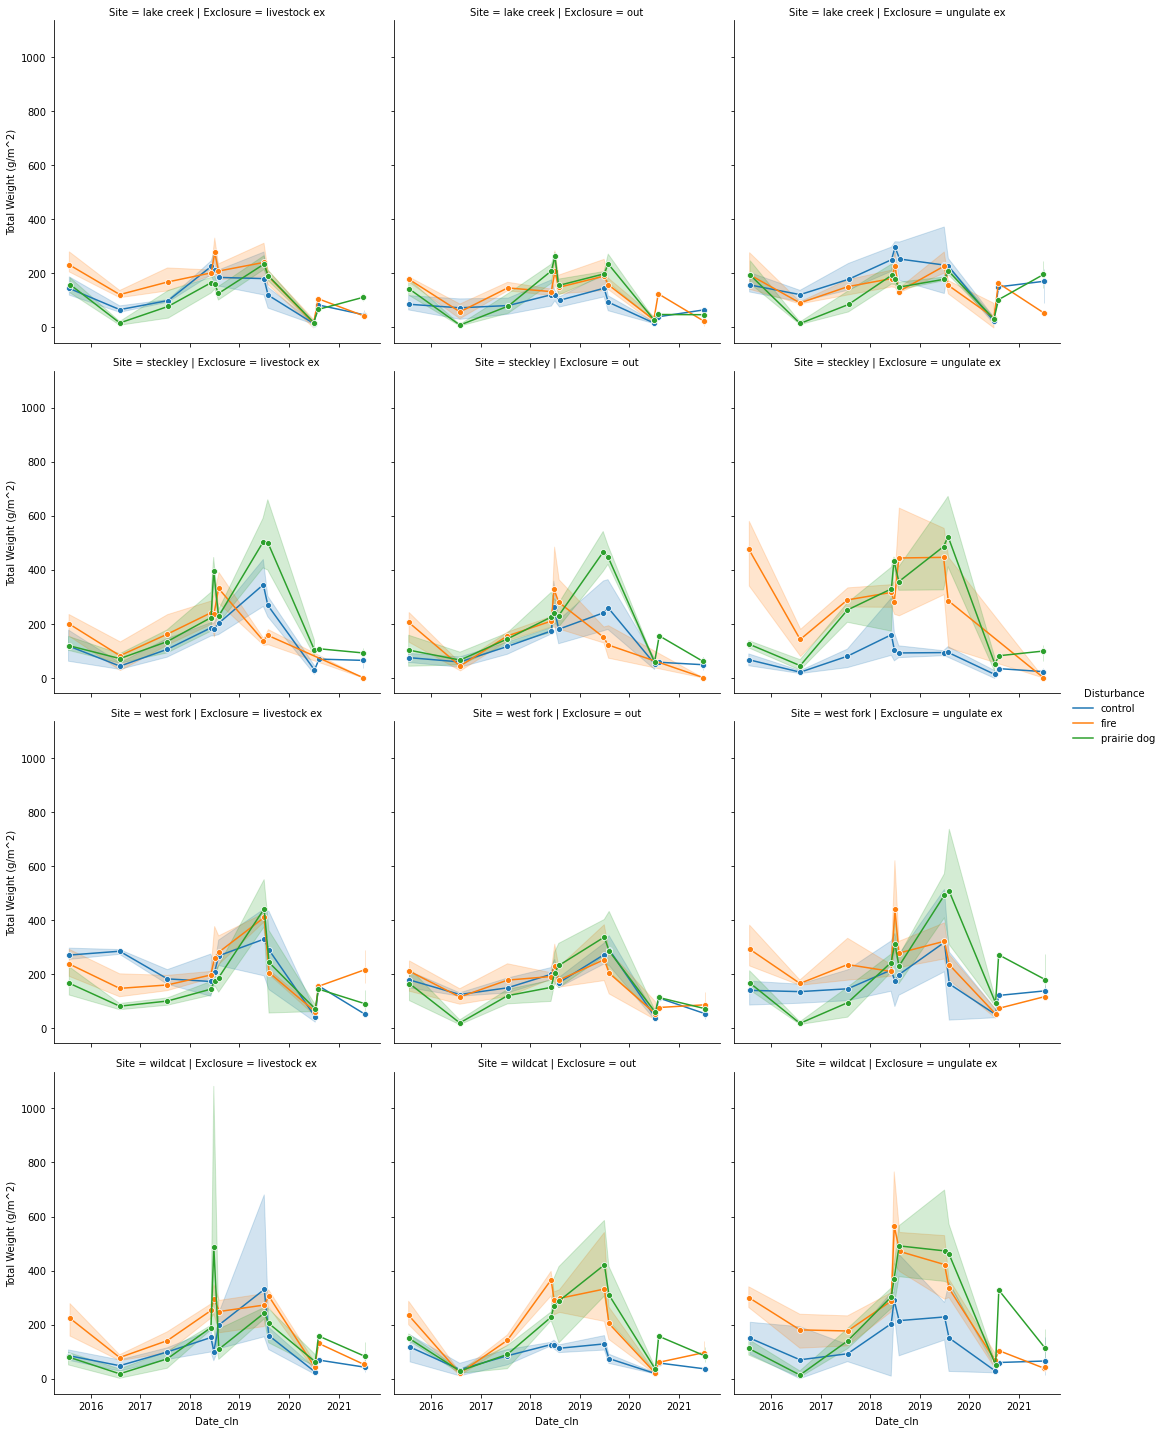

In [14]:
sns.relplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm, kind='line', marker="o")

# Pin Frame Dataset

### Combine Biomass and Pin Frame datasets

In [15]:
# Create a new column in the Pin Frame dataframe pulling the nearest Biomass sampling date
df_nex_pf = pd.merge_asof(df_nex_pf.sort_values('Date'), 
                          df_nex_bm.groupby(['Site',
                                             'Disturbance',
                                             'Exclosure',
                                             'Date_cln']).mean().reset_index().sort_values('Date_cln')[['Site',
                                                                                                        'Disturbance',
                                                                                                        'Exclosure',
                                                                                                        'Total Weight (g/m^2)',
                                                                                                        'C4 weight (g/m^2)',
                                                                                                        'C3 weight (g/m^2)', 
                                                                                                        'Bromes weight (g/m^2)', 
                                                                                                        'Forbs weight (g/m^2)', 
                                                                                                        'Ann Forb weight (g/m^2)', 
                                                                                                        'Per Forb weight (g/m^2)',
                                                                                                        'VUOC weight (g/m^2)',
                                                                                                        'Subshrub weight (g/m^2)',
                                                                                                        'Standing Dead weight (g/m^2)',
                                                                                                        'Date_cln']],
                          left_on='Date',
                          right_on='Date_cln',
                          by=['Site', 'Disturbance', 'Exclosure'],
                          direction='nearest',
                          tolerance=datetime.timedelta(days=15),
                          suffixes=['_x', ''])

In [16]:
# drop any records missing Biomass data
df_nex_pf = df_nex_pf[df_nex_pf['Total Weight (g/m^2)'].notnull()]

In [17]:
# Check that all values in the newly created column are present in the Biomass dates (result should be empty)
df_nex_pf['Date_cln'].sort_values().astype('str')[~df_nex_pf['Date_cln'].sort_values().isin(
    df_nex_bm[df_nex_bm['Year'] >= 2017]['Date_cln'])].unique()

array([], dtype=object)

### Clean up Pin Frame dataset

In [18]:
# drop basal hits
df_nex_pf = df_nex_pf[df_nex_pf['Position'] != 'basal']

# drop shrub and cactus hits since no clip data available
df_nex_pf = df_nex_pf.drop(columns='Shrub/OPPO')

In [19]:
# calculate herbaceous weight
df_nex_pf['Herb weight (g/m^2)'] = df_nex_pf['Total Weight (g/m^2)'] - df_nex_pf['Standing Dead weight (g/m^2)']

# calculate forb hits
df_nex_pf['Forb'] = df_nex_pf['AnnualForb'] + df_nex_pf['PerennialForb']

### Calculate appropriate values at the experimental unit level

In [20]:
# aggregate data by experimental unit
df_nex_pf_agg = df_nex_pf.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_cln']).aggregate(
    {'Total Hits': np.sum,
     'C4P Grass': np.sum,
     'C3P Grass': np.sum,
     'Brome': np.sum,
     'VUOC': np.sum, 
     'AnnualForb': np.sum,
     'PerennialForb': np.sum,
     'Forb': np.sum,
     'Subshrub': np.sum,
     'StandingDead': np.sum,
     'TotalHerbHits': np.sum,
     'Total Weight (g/m^2)': np.mean,
     'C4 weight (g/m^2)': np.mean,
     'C3 weight (g/m^2)': np.mean,
     'Bromes weight (g/m^2)': np.mean,
     'Forbs weight (g/m^2)': np.mean,
     'Ann Forb weight (g/m^2)': np.mean,
     'Per Forb weight (g/m^2)': np.mean,
     'VUOC weight (g/m^2)': np.mean,
     'Subshrub weight (g/m^2)': np.mean,
     'Standing Dead weight (g/m^2)': np.mean,
     'Herb weight (g/m^2)': np.mean}).reset_index()

In [21]:
pf_colname_mapper = {
    'C4P Grass': 'hits_C4',
    'C3P Grass': 'hits_C3',
    'Brome': 'hits_Brome',
    'VUOC': 'hits_VUOC',
    'AnnualForb': 'hits_AnnForb',
    'PerennialForb': 'hits_PerForb',
    'Forb': 'hits_Forb',
    'Subshrub': 'hits_Subshrub',
    'StandingDead': 'hits_SD',
    'TotalHerbHits': 'hits_Herb',
    'Total Hits': 'hits_Total',
    'C4 weight (g/m^2)': 'weight_C4',
    'C3 weight (g/m^2)': 'weight_C3',
    'Bromes weight (g/m^2)': 'weight_Brome',
    'VUOC weight (g/m^2)': 'weight_VUOC',
    'Ann Forb weight (g/m^2)': 'weight_AnnForb',
    'Per Forb weight (g/m^2)': 'weight_PerForb',
    'Forbs weight (g/m^2)': 'weight_Forb',
    'Subshrub weight (g/m^2)': 'weight_Subshrub',
    'Standing Dead weight (g/m^2)': 'weight_SD',
    'Herb weight (g/m^2)': 'weight_Herb',
    'Total Weight (g/m^2)': 'weight_Total'
}

df_nex_pf_agg = df_nex_pf_agg.rename(columns=pf_colname_mapper)

In [22]:
# reset the year column
df_nex_pf_agg['Year'] = df_nex_pf_agg['Date_cln'].dt.year

# rename date column
df_nex_pf_agg = df_nex_pf_agg.rename(columns={'Date_cln': 'Date'})

### Create long-form version of data

In [23]:
# convert to long format to be able to plot with hue as the FG
df_nex_pf_agg_long = pd.wide_to_long(df_nex_pf_agg.reset_index(), 
                                     stubnames=['hits', 'weight'], 
                                     i=['Site', 'Disturbance', 'Exclosure', 'Date'], 
                                     j='FG', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

### Check data and save to disk

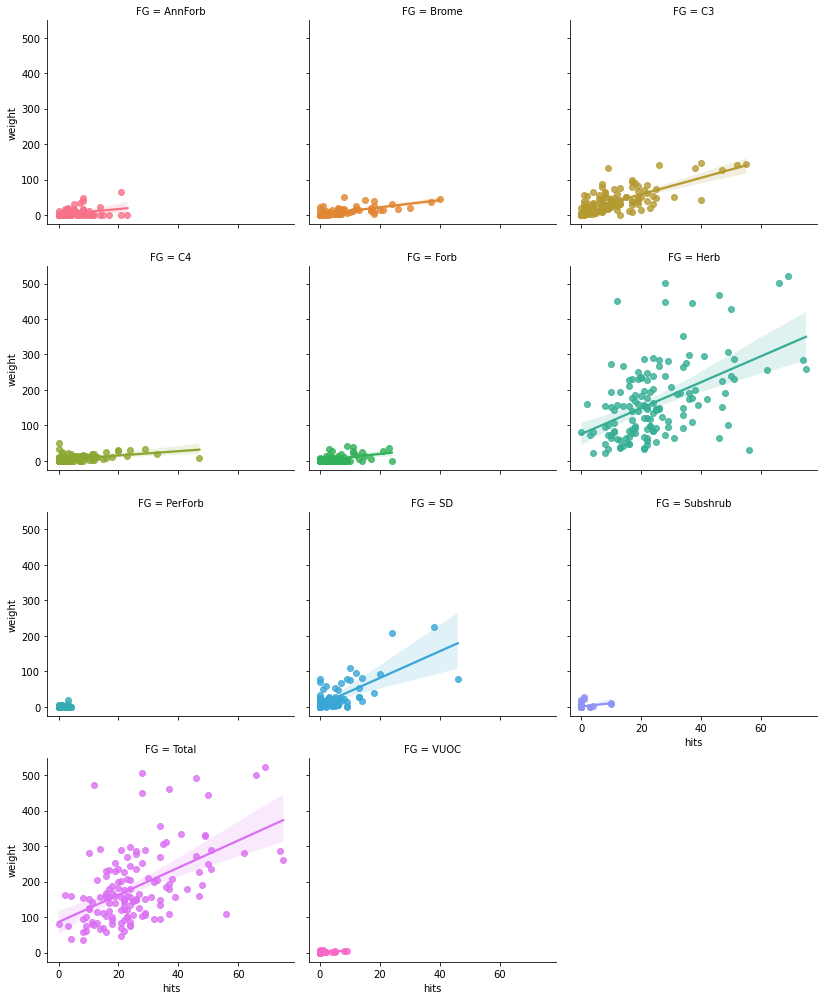

In [24]:
# plot linear fits for each functional group (FG)
sns.lmplot(x='hits',
           y='weight',
           col='FG',
           col_wrap=3,
           hue='FG',
           data=df_nex_pf_agg_long,
           scatter=True, height=3.5, aspect=1.1)

In [25]:
# drop meaningless columns
df_nex_pf_agg_long = df_nex_pf_agg_long.drop(columns=['index'])
# save datasets to disk
df_nex_pf_agg.to_csv('data/TB_nex_pf.csv', index=False)
df_nex_pf_agg_long.to_csv('data/TB_nex_pf_long.csv', index=False)

# VOR

### *Set parameters*

In [26]:
# set maximum realistic VOR
max_vor = 75

### *Combine with biomass dataset*

In [27]:
# join Biomass and VOR datasets using Biomass dates with a definted maximum threshold of date difference
df_nex_vor = pd.merge_asof(df_nex_vor.sort_values('Date_Surveyed'), 
                           df_nex_bm.groupby(['Site',
                                              'Disturbance',
                                              'Exclosure',
                                              'Date_cln']).mean().reset_index().sort_values('Date_cln')[['Site',
                                                              'Disturbance',
                                                              'Exclosure',
                                                              'Area (m^2)',
                                                              'Total Weight (g)',
                                                              'Total Weight (g/m^2)',
                                                              'Date_cln']],
                           left_on='Date_Surveyed',
                           right_on='Date_cln',
                           by=['Site', 'Disturbance', 'Exclosure'],
                           direction='nearest',
                           tolerance=datetime.timedelta(days=15),
                           suffixes=['_x', ''])

In [28]:
# drop any records missing Biomass data
df_nex_vor = df_nex_vor[df_nex_vor['Total Weight (g/m^2)'].notnull()]

In [36]:
df_nex_vor.Spp_code.unique()

array(['PASM', 'UGLY AUX', 'POSE', 'LEPE', 'ARTR', 'SATR', 'BRAR', 'CHAL',
       'ALDE', 'CHPR', 'PLPA', 'BARE', 'BASC', 'BOGR', 'KRLA', 'BRTE',
       'MONU', 'HECO', 'CAFI', 'LITTER', 'TAOF', 'SCPA', 'SOTR', 'SPCO',
       'navi', 'viam', 'artr', 'brar', 'arfr', 'cafi', 'PEAR', 'LOAR',
       'koma', 'arca', 'DEPI', 'MATA', 'basc', 'HOPU', 'alde', 'piop',
       'trdu', 'VUOC', 'ELEL', 'arpu', 'plpa', 'monu', 'poav', 'chpr',
       'lede', 'agcr', 'lepe', 'ARCA', 'TRDU', 'KOMA', 'NAVI', 'PEER',
       'AGCR', 'VIAM', 'COAR', 'TRDU ', 'HEHI', 'ARFR', 'ARLU', 'HOJU',
       'LYJU', 'SD HECO', 'GRSQ', 'COCA', 'ARPU', 'JECO', 'SD BRAR', 'AS',
       'SD ARTR', 'LICHEN', 'PHHO', 'SD NAVI', 'SD PASM', 'CADU', 'LASE',
       'SD MATA', 'HECI'], dtype=object)

In [ ]:
{'HECI': 'HECO',
 'JECO': 'HECO'}

### *Clean VOR dataset*

In [29]:
# create list of species to drop from VOR data
vor_spp_drop_list = ['ATCA', 'atca', 'OPPO', 'oppo', 'ARTR', 'artr', 'SD ARTR', 'ARCA', 'arca', 'SD ATCA']

# drop VOR readings in species list
df_nex_vor = df_nex_vor[~df_nex_vor['Spp_code'].isin(vor_spp_drop_list)]

# drop VOR with very high readings and convert 'High_cm back to integer'
df_nex_vor = df_nex_vor[df_nex_vor['High_cm'] != '90+']
df_nex_vor['High_cm'] = df_nex_vor['High_cm'].astype('int')
df_nex_vor = df_nex_vor[df_nex_vor['High_cm'] < max_vor]

# drop VOR where low > high as suspected data entry errors
df_nex_vor = df_nex_vor[df_nex_vor['Low_cm'] <= df_nex_vor['High_cm']]

### *Create dataset of mean values by experimental unit*

In [30]:
# get mean of each experimental unit
df_nex_vor_agg = df_nex_vor.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_cln']).mean().reset_index()

# reset the year column
df_nex_vor_agg['Year'] = df_nex_vor_agg['Date_cln'].dt.year

# drop meaningless columns
df_nex_vor_agg = df_nex_vor_agg.drop(columns=['Distance_along_transect_m'])

# rename date columns
df_nex_vor_agg = df_nex_vor_agg.rename(columns={'Date_cln': 'Date'})

### *Check data and save to disk*

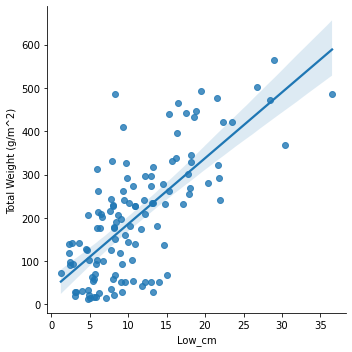

In [31]:
# plot linear fit of low VOR reading and Biomass
sns.lmplot(x='Low_cm', 
           y='Total Weight (g/m^2)',
          data=df_nex_vor_agg)

In [32]:
# save final data to disk
df_nex_vor_agg.to_csv('data/TB_nex_vor.csv', index=False)

# Questions
### Biomass 
* What is the Rep? Only one rep for Pin frame and 3 reps for BM..
  * should I average all reps or just take Rep 1?
 
### Pin frame 
* What should be the final functional groups?
  * currently considering:
     * Annuals (BROME + VUOC)
     * Forbs (PerFORB + AnnFORB)
     * C3
     * C4
     * Subshrub
* How to combine functional group in model?
  * currently planning separate models for each FG
* What is TotalHerbHits? Do I need to calculate herb weight?
  * currently I am calculaing an herb weight from biomass clipping as: Total - SD
* Should I be dropping basal hits?
* Ok to drop Shrub/Oppo (no corresponding Biomass clipping)
  * or should we sites with high shrub/oppo?
* PASM vs. COMP? (!this is just for FQ)

### VOR 
* Which species to drop from VOR?
  * for CPER we dropped: ['OPPO', 'ATCA', 'GUSA', 'EREF', 'ARFR', 'ERNA', 'KRLA', 'YUGL']
  * currently I am just dropping OPPO and ATCA
* Should I clean up outliers?
  * for CPER we used cut-off of 50 cm height (for high) and 2.5 sd's
  * currently I am removing high > 75 cm and low > high
* Max date difference between clipping and VOR?
  * currently I am using 15 days
  
### PVSAGE
* Anything different to be aware of?
* Only use pre-treatment data for satellite extraction?
    * Is the first year (2016?) baseline data pre-treatment? 

In [ ]:
# remove negative values
# red cells will be NAN (check latest saved data)
# Note that there is biomass data with no corresponding PF data (and not by FG)
# drop all biomass data not used for pin frame calibration before PF join (then you won't be worrying about reps).
# Add BOGR/BUDA back into C4 when present (starting in 2020)
# drop all PASM data from Biomass
# starting in 2019 need to add together annual and perennial forbs, but prior is just forbs

# VOR
# leave all high numbers. Change 90+ to 90
# could check datasheets when low > high (ask Katie)
# change date tolerance to 10 days max (look at VOR, should through out all of 2015-17, but very few in 2018+),
#maybe reduce tolerance if needbe